In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-type-classification/weather_classification_data.csv


# Project. Weather Type 
## Goal
> ## Modeling :  Predicting Weather Type 

In [2]:
# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# For Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

2024-06-24 12:39:23.568223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 12:39:23.568334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 12:39:23.681201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/weather-type-classification/weather_classification_data.csv')
df

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy
...,...,...,...,...,...,...,...,...,...,...,...
13195,10.0,74,14.5,71.0,overcast,1003.15,1,Summer,1.0,mountain,Rainy
13196,-1.0,76,3.5,23.0,cloudy,1067.23,1,Winter,6.0,coastal,Snowy
13197,30.0,77,5.5,28.0,overcast,1012.69,3,Autumn,9.0,coastal,Cloudy
13198,3.0,76,10.0,94.0,overcast,984.27,0,Winter,2.0,inland,Snowy


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
col_name_object = df.select_dtypes(include='object').columns.tolist()
col_name_num = df.select_dtypes(include=['float64','int64']).columns.tolist()

for col in col_name_object:
    print(f"Column '{col}' unquie values: {df[col].unique()}")

Column 'Cloud Cover' unquie values: ['partly cloudy' 'clear' 'overcast' 'cloudy']
Column 'Season' unquie values: ['Winter' 'Spring' 'Summer' 'Autumn']
Column 'Location' unquie values: ['inland' 'mountain' 'coastal']
Column 'Weather Type' unquie values: ['Rainy' 'Cloudy' 'Sunny' 'Snowy']


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,13200.0,19.127576,17.386327,-25.00,4.0,21.00,31.0000,109.00
Humidity,13200.0,68.710833,20.194248,20.00,57.0,70.00,84.0000,109.00
Wind Speed,13200.0,9.832197,6.908704,0.00,5.0,9.00,13.5000,48.50
Precipitation (%),13200.0,53.644394,31.946541,0.00,19.0,58.00,82.0000,109.00
Atmospheric Pressure,13200.0,1005.827896,37.199589,800.12,994.8,1007.65,1016.7725,1199.21
UV Index,13200.0,4.005758,3.856600,0.00,1.0,3.00,7.0000,14.00
Visibility (km),13200.0,5.462917,3.371499,0.00,3.0,5.00,7.5000,20.00


# EDA : Column Analysis

In [7]:
fig = go.Figure()

for col in col_name_num:
    fig = go.Figure()
    fig.add_trace(go.Box(y=df[col], name=col))

    fig.update_layout(
        title=f"Box Plot for {col}",
        yaxis_title="Values",
        title_font_size=25,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white')
    )

    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', griddash='dash')

    fig.show()

# Modeling : MLP (Multi-Layer Perceptron)

In [8]:
label_encoders = {}

for col in col_name_object:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop('Weather Type', axis=1)
y = df['Weather Type']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_encoded = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [9]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(y_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
 92/330 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3283 - loss: 1.4344

I0000 00:00:1719232779.430861      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719232779.447636      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


310/330 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4808 - loss: 1.1972

W0000 00:00:1719232780.451217      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4900 - loss: 1.1823 - val_accuracy: 0.8508 - val_loss: 0.5090
Epoch 2/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7789 - loss: 0.6711 - val_accuracy: 0.8678 - val_loss: 0.4222
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8239 - loss: 0.5617 - val_accuracy: 0.8761 - val_loss: 0.3722
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8422 - loss: 0.4933 - val_accuracy: 0.8758 - val_loss: 0.3466
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8508 - loss: 0.4623 - val_accuracy: 0.8826 - val_loss: 0.3225
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8606 - loss: 0.4260 - val_accuracy: 0.8871 - val_loss: 0.2985
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8642 - loss: 0.4064 - val_accuracy: 0.8924 - val_loss: 0.2826
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8674 - loss: 0.3758 - val_accuracy: 0.8947 - val_

# Evaluation

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Accuracy: {accuracy:.4f}\n')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

target_names = list(label_encoders['Weather Type'].classes_)
print("Classification Report:\n")
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9068 - loss: 0.2048
Validation Accuracy: 0.9045

43/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

W0000 00:00:1719232815.627831      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:

              precision    recall  f1-score   support

      Cloudy       0.97      0.84      0.90       651
       Rainy       0.93      0.89      0.91       647
       Snowy       0.99      0.93      0.96       701
       Sunny       0.77      0.97      0.86       641

    accuracy                           0.90      2640
   macro avg       0.91      0.90      0.91      2640
weighted avg       0.92      0.90      0.91      2640



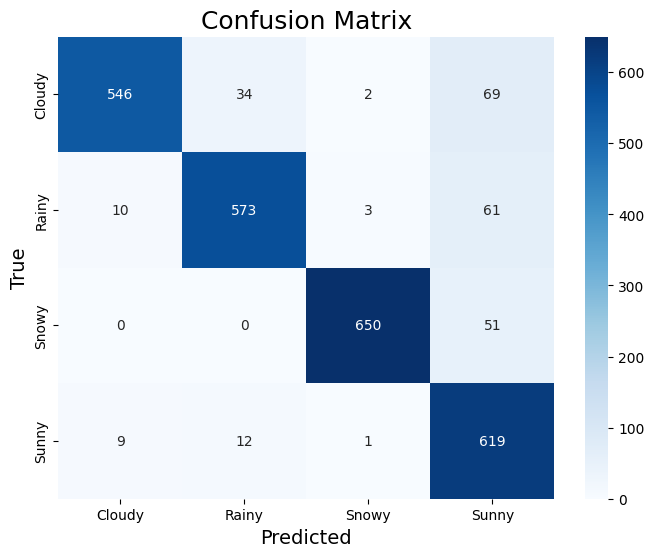

In [11]:
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted', fontsize= 14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Thanks